In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

In [ ]:
train_data = datasets.CIFAR10(root="./data", train=True,
                              download=True, transform=transform_train)
test_data = datasets.CIFAR10(root="./data", train=False,
                             download=True, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

classes = train_data.classes

100%|██████████| 170M/170M [00:05<00:00, 31.3MB/s]


In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# alexnet = models.alexnet(weights=None)
# alexnet.classifier[6] = nn.Linear(4096, 10)
class AlexNet_CIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

alexnet = AlexNet_CIFAR().to(device)

In [ ]:
vgg16 = models.vgg16(weights=None)
vgg16.classifier[6] = nn.Linear(4096, 10)

In [ ]:
res50 = models.resnet50(weights=None)
res50.fc = nn.Linear(2048, 10)

In [ ]:
res101 = models.resnet101(weights=None)
res101.fc = nn.Linear(2048, 10)

In [ ]:
mobilenet = models.mobilenet_v2(weights=None)
mobilenet.classifier[1] = nn.Linear(1280, 10)

In [ ]:
efficientnet = models.efficientnet_b0(weights=None)
efficientnet.classifier[1] = nn.Linear(1280, 10)

In [ ]:
inception = models.inception_v3(weights=None, aux_logits=False)
inception.fc = nn.Linear(2048, 10)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
models_dict = {
    "LeNet5": LeNet5().to(device),
    "AlexNet": AlexNet_CIFAR().to(device),
    "VGG16": vgg16.to(device),
    "ResNet50": res50.to(device),
    "ResNet101": res101.to(device),
    "MobileNetV2": mobilenet.to(device),
    "EfficientNetB0": efficientnet.to(device),
    "InceptionV3": inception.to(device)
}

In [ ]:
bce_loss = nn.BCEWithLogitsLoss()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        ce_loss = self.ce(logits, labels)
        pt = torch.exp(-ce_loss)
        return (1-pt)**self.gamma * ce_loss

focal_loss = FocalLoss()

In [ ]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes=10, embedding_size=128, margin=0.5, scale=64):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embedding_size, num_classes))
        nn.init.xavier_normal_(self.W)
        self.margin = margin
        self.scale = scale

    def forward(self, emb, labels):
        x = F.normalize(emb)
        W = F.normalize(self.W)
        logits = torch.matmul(x, W)

        theta = torch.acos(torch.clamp(logits, -1+1e-7, 1-1e-7))
        target_logits = torch.cos(theta + self.margin)

        logits_scaled = logits.clone()
        logits_scaled[range(len(labels)), labels] = target_logits[range(len(labels))]

        return F.cross_entropy(self.scale * logits_scaled, labels)

arcface_loss = ArcFaceLoss()

In [ ]:
def train_model(model, criterion, optimizer, epochs=10, loss_name="CE"):
    model.train()
    train_acc_list, train_loss_list = [], []
    start = time.time()

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            if loss_name == "ArcFace":
                features = model.forward(images)
                loss = criterion(features, labels)
                outputs = features
            elif loss_name == "BCE":
                outputs = model(images)
                labels_oh = F.one_hot(labels, 10).float()
                loss = criterion(outputs, labels_oh)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100 * correct / total
        train_acc_list.append(acc)
        train_loss_list.append(epoch_loss / len(train_loader))

        print(f"Epoch {epoch+1}/{epochs} | Loss={loss.item():.4f} | Acc={acc:.2f}%")

    return train_acc_list, train_loss_list, time.time() - start

In [ ]:
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    preds, trues = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            preds.extend(predicted.cpu().numpy())
            trues.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100 * correct / total
    return acc, preds, trues

TASK 1

In [ ]:
results = {}   # Stores completed models
trained_models = set()   # Track models already done

for name, model in models_dict.items():
    print("Now training:", name)

    if name in trained_models:
        print(f"{name} already trained. Skipping...")
        continue

    try:
        # Train
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        train_acc, train_loss, t = train_model(
            model, criterion, optimizer, epochs=10
        )

        # Evaluate
        test_acc, _, _ = evaluate(model)

        # Save result
        results[name] = {
            "train_acc": train_acc[-1],
            "test_acc": test_acc,
            "train_time": t
        }

        # Mark as trained
        trained_models.add(name)

        print(f"Completed: {name}")
        print(results[name])

    except Exception as e:
        print(f"Error occurred while training {name}: {e}")
        print("Skipping this model and moving to the next.\n")
        continue

print("\nRESULTS")
for k, v in results.items():
    print(k, v)

Now training: LeNet5
Epoch 1/10 | Loss=1.2510 | Acc=54.55%
Epoch 2/10 | Loss=1.2124 | Acc=55.30%
Epoch 3/10 | Loss=1.2416 | Acc=56.08%
Epoch 4/10 | Loss=1.2624 | Acc=56.38%
Epoch 5/10 | Loss=1.2522 | Acc=56.89%
Epoch 6/10 | Loss=1.1184 | Acc=57.70%
Epoch 7/10 | Loss=1.1065 | Acc=58.45%
Epoch 8/10 | Loss=1.0337 | Acc=58.88%
Epoch 9/10 | Loss=1.2450 | Acc=58.88%
Epoch 10/10 | Loss=0.9885 | Acc=59.73%
Completed: LeNet5
{'train_acc': 59.732, 'test_acc': 61.76, 'train_time': 205.13978838920593}
Now training: AlexNet
Epoch 1/10 | Loss=0.5831 | Acc=73.88%
Epoch 2/10 | Loss=0.6017 | Acc=75.07%
Epoch 3/10 | Loss=0.7254 | Acc=76.02%
Epoch 4/10 | Loss=0.6920 | Acc=76.81%
Epoch 5/10 | Loss=0.6436 | Acc=77.40%
Epoch 6/10 | Loss=0.8462 | Acc=77.85%
Epoch 7/10 | Loss=0.7598 | Acc=78.48%
Epoch 8/10 | Loss=0.5331 | Acc=79.29%
Epoch 9/10 | Loss=0.5724 | Acc=79.31%
Epoch 10/10 | Loss=0.7165 | Acc=80.06%
Completed: AlexNet
{'train_acc': 80.064, 'test_acc': 79.7, 'train_time': 300.84412479400635}
Now train

TASK 2

In [ ]:
print("\nVGG + BCE")
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)
train_model(vgg16, bce_loss, optimizer, epochs=10, loss_name="BCE")
bce_test,_,_ = evaluate(vgg16)

# AlexNet + Focal Loss
print("\nAlexNet + Focal")
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
train_model(alexnet, focal_loss, optimizer, epochs=20, loss_name="Focal")
focal_test,_,_ = evaluate(alexnet)

# ResNet + ArcFace
print("\nResNet50 + ArcFace")
optimizer = optim.Adam(res50.parameters(), lr=0.001)
train_model(res50, arcface_loss, optimizer, epochs=15, loss_name="ArcFace")
arcface_test,_,_ = evaluate(res50)

print("\nRESULTS")
print("VGG + BCE:", bce_test)
print("AlexNet + Focal:", focal_test)
print("ResNet + ArcFace:", arcface_test)



VGG + BCE
Epoch 1/10 | Loss=0.5630 | Acc=10.00%
Epoch 2/10 | Loss=0.4755 | Acc=10.00%
Epoch 3/10 | Loss=0.4183 | Acc=10.00%
Epoch 4/10 | Loss=0.3813 | Acc=10.00%
Epoch 5/10 | Loss=0.3580 | Acc=10.00%
Epoch 6/10 | Loss=0.3436 | Acc=10.00%
Epoch 7/10 | Loss=0.3349 | Acc=10.00%
Epoch 8/10 | Loss=0.3299 | Acc=9.92%
Epoch 9/10 | Loss=0.3273 | Acc=9.73%
Epoch 10/10 | Loss=0.3260 | Acc=9.83%

AlexNet + Focal
Epoch 1/20 | Loss=1.4547 | Acc=12.71%
Epoch 2/20 | Loss=0.9627 | Acc=29.77%
Epoch 3/20 | Loss=0.9971 | Acc=40.24%
Epoch 4/20 | Loss=0.9989 | Acc=48.33%
Epoch 5/20 | Loss=0.3949 | Acc=53.91%
Epoch 6/20 | Loss=0.3562 | Acc=59.29%
Epoch 7/20 | Loss=0.3576 | Acc=63.77%
Epoch 8/20 | Loss=0.3865 | Acc=67.05%
Epoch 9/20 | Loss=0.1831 | Acc=69.90%
Epoch 10/20 | Loss=0.2125 | Acc=72.02%
Epoch 11/20 | Loss=0.2987 | Acc=73.91%
Epoch 12/20 | Loss=0.2092 | Acc=75.36%
Epoch 13/20 | Loss=0.1088 | Acc=76.99%
Epoch 14/20 | Loss=0.0444 | Acc=78.43%
Epoch 15/20 | Loss=0.2207 | Acc=79.06%
Epoch 16/20 | Loss

RuntimeError: Expected all tensors to be on the same device, but got mat2 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_mm)

TASK 3

In [ ]:
def extract_features(model):
    model.eval()
    feats, labels_list = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            feats.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())

    feats = np.concatenate(feats, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    return feats, labels_list

In [ ]:
bce_feats, bce_labels = extract_features(vgg16)
arc_feats, arc_labels = extract_features(res50)

tsne = TSNE(n_components=2, perplexity=40, learning_rate=200)
bce_tsne = tsne.fit_transform(bce_feats[:2000])
arc_tsne = tsne.fit_transform(arc_feats[:2000])

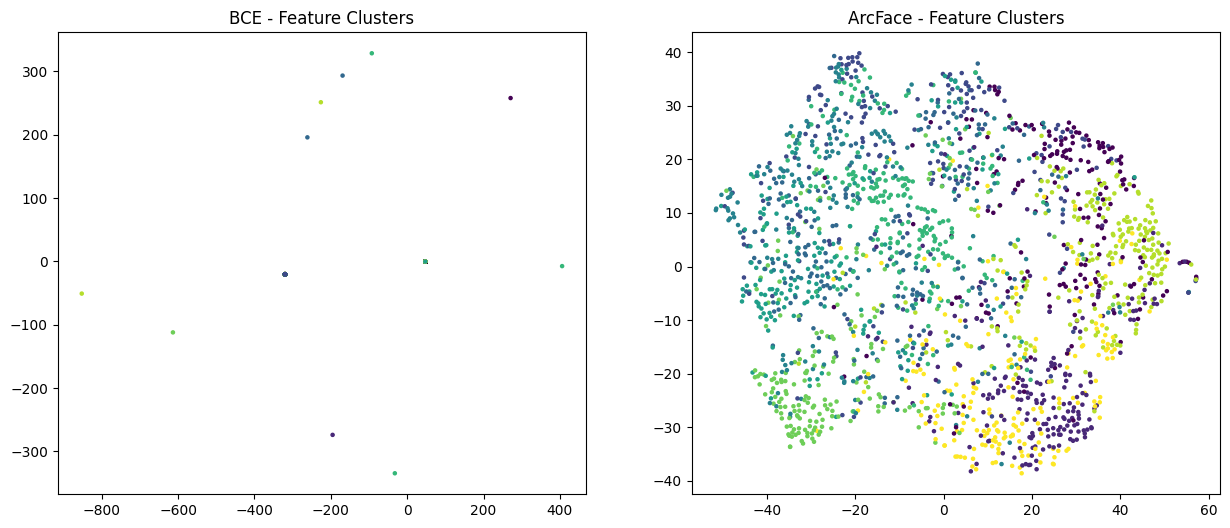

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(bce_tsne[:,0], bce_tsne[:,1], c=bce_labels[:2000], s=5)
plt.title("BCE - Feature Clusters")

plt.subplot(1,2,2)
plt.scatter(arc_tsne[:,0], arc_tsne[:,1], c=arc_labels[:2000], s=5)
plt.title("ArcFace - Feature Clusters")
plt.show()